In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

from pathlib import Path
import pandas as pd

image_dir = Path('/Users/nijat/Downloads/split_data/')


filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r"**/**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

image_df = image_df.sample(frac=1).reset_index(drop=True)

image_df['dataset'] = image_df['Filepath'].apply(lambda x: x.split('/')[-3])

train_df = image_df[image_df['dataset']=='train']
test_df = image_df[image_df['dataset']=='test']

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Ignore errors if no GPU is found
  pass

print(physical_devices)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

pretrained_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Update input shape as required
    #pooling='avg'
)
pretrained_model.trainable = False
pretrained_model.summary()

output = pretrained_model.output

# Apply the new Conv2d block to the output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv1')(output)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv2')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv3')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='block6_gap')(x)
x = tf.keras.layers.Flatten(name='block7_flatten')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create a new model with the combined layers
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x, name='LungNet22')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 3245 validated image filenames belonging to 10 classes.
Found 811 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


2024-04-18 18:17:43.024720: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 18:17:43.024740: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-04-18 18:17:43.024746: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-04-18 18:17:43.024764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 18:17:43.024777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [2]:
model.compile(
    optimizer='AdamW',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [3]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300


2024-04-18 18:17:45.530251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.2681 - loss: 3.2838 - val_accuracy: 0.5795 - val_loss: 1.1470
Epoch 2/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6268 - loss: 1.0264 - val_accuracy: 0.6967 - val_loss: 0.8493
Epoch 3/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7464 - loss: 0.7254 - val_accuracy: 0.7448 - val_loss: 0.7469
Epoch 4/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7881 - loss: 0.5878 - val_accuracy: 0.7941 - val_loss: 0.5793
Epoch 5/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8524 - loss: 0.4001 - val_accuracy: 0.8237 - val_loss: 0.5210
Epoch 6/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8880 - loss: 0.3154 - val_accuracy: 0.8594 - val_loss: 0.4407
Epoch 7/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9133 - loss: 0.2340 - val_accuracy: 0.9026 - val_loss: 0.3395
Epoch 8/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9326 - loss: 0.2060 - val_accura

In [8]:
model.save('LungNet22_EfficientNetV2B0_AdamW.keras')

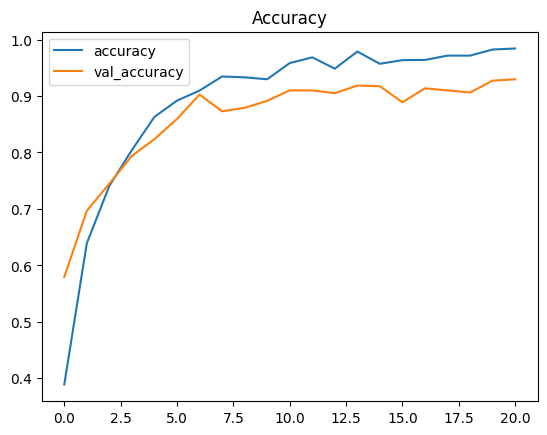

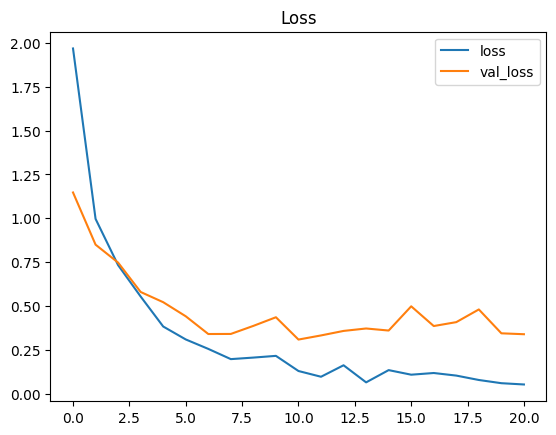

    Test Loss: 0.27147
Test Accuracy: 93.52%


In [9]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()


results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [10]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]
print(f'The first 6 predictions: {pred[:6]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
The first 6 predictions: ['mass', 'pneumothorax', 'effusion', 'control', 'effusion', 'tuberculosis']


                    precision    recall  f1-score   support

           control       1.00      1.00      1.00       116
             covid       0.98      0.99      0.99       101
          effusion       0.91      0.91      0.91       100
      lung Opacity       0.99      0.90      0.94       100
              mass       0.94      0.86      0.90       101
            nodule       0.90      0.94      0.92       101
         pneumonia       0.85      0.94      0.89       100
      pneumothorax       0.86      0.93      0.89       100
pulmunary fibrosis       0.94      0.94      0.94        99
      tuberculosis       1.00      0.93      0.96       101

          accuracy                           0.94      1019
         macro avg       0.94      0.93      0.93      1019
      weighted avg       0.94      0.94      0.94      1019



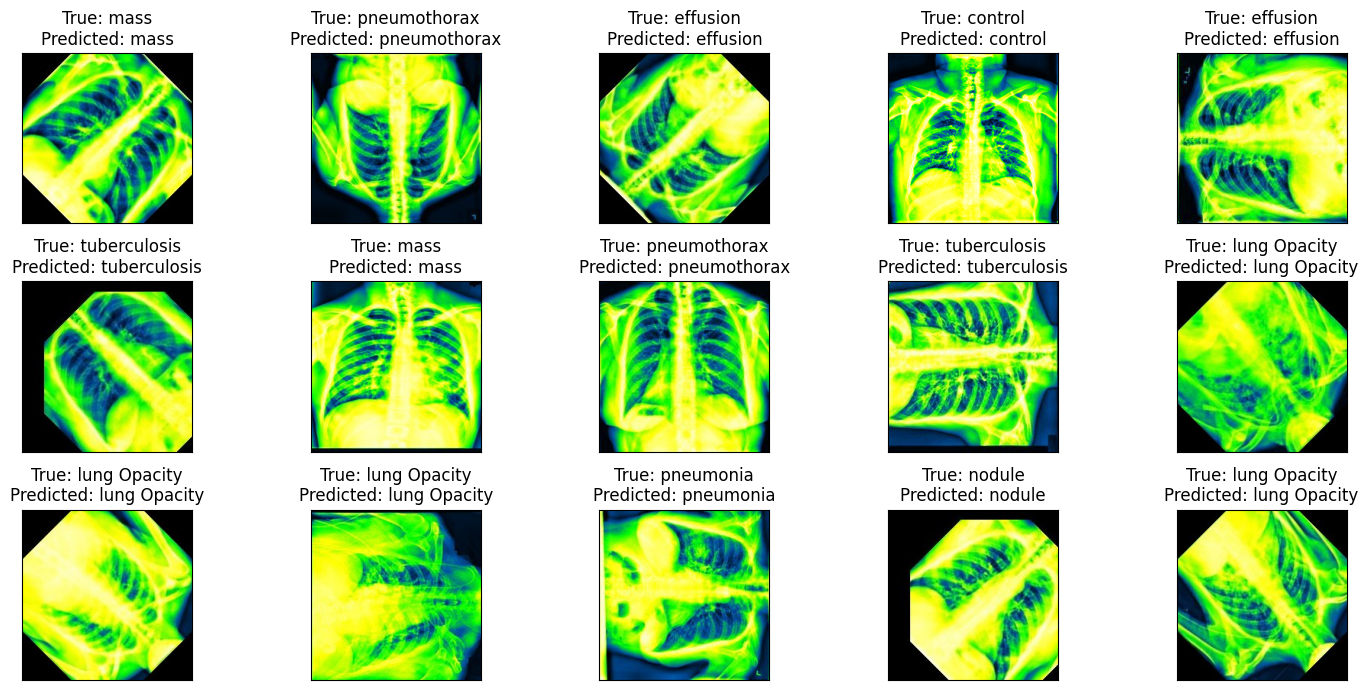

In [11]:
from sklearn.metrics import classification_report

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()